In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from src.data_loading import DlDataset
from src.utils import plot_performance
from src.convnet import do_train_trials, train_net, evaluate_net_classes, NumNet, ModelPerformanceSummary

import matplotlib.pyplot as plt

In [3]:
# Not very elegant but removes all the warnings about deprecated upsample funtion
import warnings
warnings.filterwarnings("ignore")

# Training for the boolean target

In [4]:
#import data for a 1000 pairs
N = 1000
dataset = DlDataset(N, normalize=True, upsample=None)
datasetShape = list(dataset.__shape__()[1:])

device = torch.device('cpu') #Hannes' gpu is not supported but has cuda cores... 

** Model architectures **
Number of trainable paramaters should be below 100'000
1. 2 conv layers, 2 linear layers, no batch norm
2. 2 conv layers, 2 batch norm layers, 2 linear layers
3. 3 conv layers, 2 linear layers, no batch norm
4. 2 conv layers, 2 batch norm layers, 2 linear layers, 1 dropout layer

In [5]:
# The same net using NumNet class
# Dropout layer
# {'Type':'DropoutLayer', 'p':0.2}
models = []

# 2 convolutional layers followed by 2 linear layers
config_2c_2l = [{'Type': 'ConvLayer', 'out_channels':8, 'activation':'ReLU()', 'kernel_size':5},
          {'Type': 'ConvLayer', 'out_channels':16, 'activation':'ReLU()', 'kernel_size':3},
          {'Type': 'LinearLayer', 'out_features':32, 'activation':'ReLU()'},
          {'Type': 'LinearLayer', 'out_features':2}]
models.append(NumNet(datasetShape, config_2c_2l, name='2conv_2lin'))

# 2 convolutional layers followed by 2 linear layers with batch norm after each conv layer
config_2c_2l_2bn = [{'Type': 'ConvLayer', 'out_channels':8, 'activation':'ReLU()', 'kernel_size':5},
          {'Type': 'BatchNormLayer'},
          {'Type': 'ConvLayer', 'out_channels':16, 'activation':'ReLU()', 'kernel_size':3},
          {'Type': 'BatchNormLayer'},
          {'Type': 'LinearLayer', 'out_features':32, 'activation':'ReLU()'},
          {'Type': 'LinearLayer', 'out_features':2}]
models.append(NumNet(datasetShape, config_2c_2l_2bn, name='2conv_2lin_bnorm'))

# 3 convolutional layers followed by 2 linear layers
config_3c_2l = [{'Type': 'ConvLayer', 'out_channels':4, 'activation':'ReLU()', 'kernel_size':5},
          {'Type': 'ConvLayer', 'out_channels':8, 'activation':'ReLU()', 'kernel_size':3},
          {'Type': 'ConvLayer', 'out_channels':16, 'activation':'ReLU()', 'kernel_size':3},
          {'Type': 'LinearLayer', 'out_features':32, 'activation':'ReLU()'},
          {'Type': 'LinearLayer', 'out_features':2}]
models.append(NumNet(datasetShape, config_3c_2l, name='3conv_2lin'))

# 2 convolutional layers with batch norm and 1 maxpool and 1 dropout, followed by 2 linear layers 
config_2c_2l_2bn_1do = [{'Type': 'ConvLayer', 'out_channels':32, 'activation':'ReLU()', 'kernel_size':5},
          {'Type': 'MaxPoolLayer', 'pooling':2, 'stride':2},
          {'Type': 'BatchNormLayer'},
          {'Type': 'DropoutLayer', 'p':0.5},
          {'Type': 'ConvLayer', 'out_channels':64, 'activation':'ReLU()', 'kernel_size':3},
          #{'Type': 'MaxPoolLayer', 'pooling':2, 'stride':2},
          {'Type': 'BatchNormLayer'},
          {'Type': 'LinearLayer', 'out_features':128, 'activation':'ReLU()'},
          #{'Type': 'DropoutLayer', 'p':0.5},
          {'Type': 'LinearLayer', 'out_features':2}]
models.append(NumNet(datasetShape, config_2c_2l_2bn_1do, name='2conv_2lin_2bn_1do'))

for model in models:
    model.summary()

 
Model '2conv_2lin'
Number              Layer               Input shape         Output shape        Trainable params    
0                   Conv2d              [2, 14, 14]         [8, 10, 10]         408
1                   Conv2d              [8, 10, 10]         [16, 8, 8]          1168
2                   Linear              1024                32                  32800
3                   Linear              32                  2                   66
----------------------------------------------------------------------------------------------------
Total number of trainable parameters: 34442
----------------------------------------------------------------------------------------------------
 
Model '2conv_2lin_bnorm'
Number              Layer               Input shape         Output shape        Trainable params    
0                   Conv2d              [2, 14, 14]         [8, 10, 10]         408
1                   BatchNorm2d         [8, 10, 10]         [8, 10, 10]         16

In [6]:
# Train parameter
epochs = 15
eta = 5e-2
lambda_l2 = 1e-3
gamma = 0.2
depth = 4
n_filters = 3
batch_spec = {'batch_size':100, 'shuffle':True, 'num_workers':4}

criterion = torch.nn.CrossEntropyLoss()

# Prepare dataloader£
dataloader = []
for mode in ['train','test']:
    if mode == 'train':
        dataset.train()
    elif mode == 'test':
        dataset.test()
    dataloader.append(dataset.return_dataloader(**batch_spec))


** A single training run using the 'train_net' function: **

In [7]:
# Train each model with the same parameters
perf_summary = []
for model in models[1:4]:
    print("-"*100)
    print("Running model: {}".format(model.name()))
    print("-"*100)
    optim = torch.optim.SGD(model.parameters(), lr=eta, momentum=gamma)
    #optim = torch.optim.Adam(model.parameters(), lr=0.001)
    performance, model = train_net(model, device, optim, criterion, dataloader,
                                    epochs=epochs, lambda_=1e-3, reg_type=None, 
                                    save=False)
    perf_summary.append(ModelPerformanceSummary(model, performance))

----------------------------------------------------------------------------------------------------
Running model: 2conv_2lin_bnorm
----------------------------------------------------------------------------------------------------
Epoch 0: Duration: 0.46s, Train Loss: 6.36e-03, Train Acc: 0.64, Val Loss: 5.94e-03, Val Acc: 0.73
Epoch 1: Duration: 0.44s, Train Loss: 4.94e-03, Train Acc: 0.79, Val Loss: 4.84e-03, Val Acc: 0.82
Epoch 2: Duration: 0.44s, Train Loss: 4.24e-03, Train Acc: 0.83, Val Loss: 3.95e-03, Val Acc: 0.86
Epoch 3: Duration: 0.45s, Train Loss: 3.81e-03, Train Acc: 0.84, Val Loss: 3.45e-03, Val Acc: 0.88
Epoch 4: Duration: 0.52s, Train Loss: 3.34e-03, Train Acc: 0.87, Val Loss: 2.91e-03, Val Acc: 0.90
Epoch 5: Duration: 0.43s, Train Loss: 3.02e-03, Train Acc: 0.89, Val Loss: 2.61e-03, Val Acc: 0.91
Epoch 6: Duration: 0.46s, Train Loss: 2.68e-03, Train Acc: 0.90, Val Loss: 2.24e-03, Val Acc: 0.93
Epoch 7: Duration: 0.47s, Train Loss: 2.41e-03, Train Acc: 0.91, Val Loss

Model: 2conv_2lin_bnorm      train_loss           min: 0.001 max: 0.006
Model: 2conv_2lin_bnorm      test_loss            min: 0.001 max: 0.006
Model: 2conv_2lin_bnorm      train_accuracy       min: 0.637 max: 0.994
Model: 2conv_2lin_bnorm      test_accuracy        min: 0.733 max: 0.995
Model: 3conv_2lin            train_loss           min: 0.005 max: 0.024
Model: 3conv_2lin            test_loss            min: 0.004 max: 0.007
Model: 3conv_2lin            train_accuracy       min: 0.564 max: 0.749
Model: 3conv_2lin            test_accuracy        min: 0.604 max: 0.767
Model: 2conv_2lin_2bn_1do    train_loss           min: 0.003 max: 0.007
Model: 2conv_2lin_2bn_1do    test_loss            min: 0.002 max: 0.006
Model: 2conv_2lin_2bn_1do    train_accuracy       min: 0.582 max: 0.871
Model: 2conv_2lin_2bn_1do    test_accuracy        min: 0.747 max: 0.937


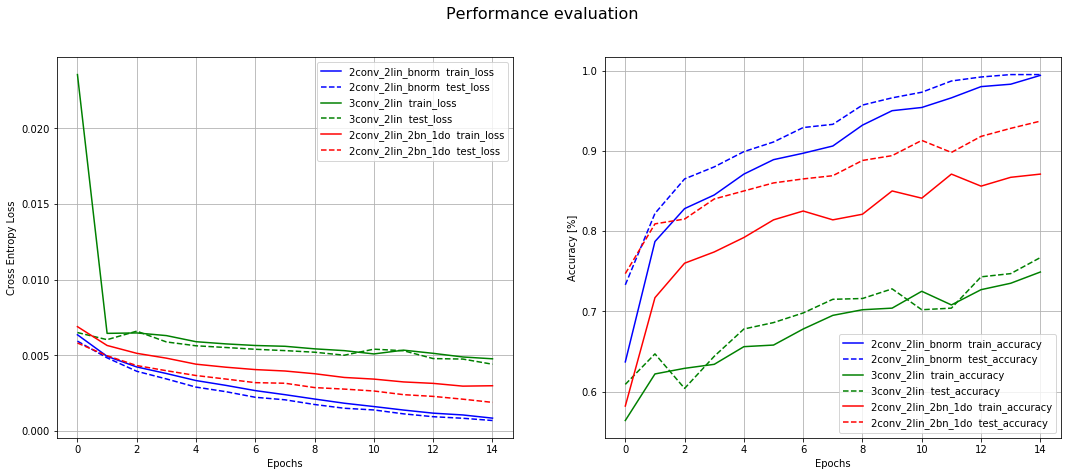

In [21]:
# Plot stuff
axes, extrema = plot_performance(perf_summary, [['train_loss','test_loss'],['train_accuracy','test_accuracy']], suptitle='Performance evaluation')
axes[0].set_ylabel('Cross Entropy Loss')
axes[1].set_ylabel('Accuracy [%]');

Predicted Target: 1, Real Target: 1
Real classes are, left: 0 right: 0
Predicted Target: 0, Real Target: 0
Real classes are, left: 7 right: 6


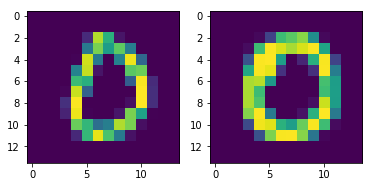

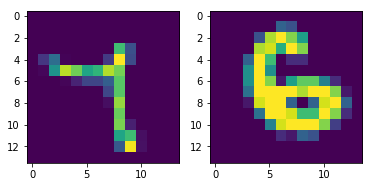

In [9]:
dataset.test()
dataset.infere(models[3],5);
dataset.infere(models[3],6);

** Multiple training trials using the 'do_train_trials' function: **

In [10]:
trial_summaries = []
for model in models[1:4]:
    print("-"*100)
    print("Running model: {}".format(model.name()))
    print("-"*100)
    optim_spec = {'type':'SGD', 'lr':eta, 'momentum':gamma}
    batch_spec = {'batch_size': 100, 'shuffle':True, 'num_workers':4}
    
    performance = do_train_trials(5, model, device, optim_spec, criterion, dataset, batch_spec,
                                    epochs=epochs, lambda_=1e-3, reg_type=None, 
                                    save=False)
    trial_summaries.append(performance)

----------------------------------------------------------------------------------------------------
Running model: 2conv_2lin_bnorm
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Running Trial: 0
----------------------------------------------------------------------------------------------------
Epoch 0: Duration: 0.40s, Train Loss: 6.89e-03, Train Acc: 0.59, Val Loss: 5.69e-03, Val Acc: 0.73
Epoch 1: Duration: 0.39s, Train Loss: 4.73e-03, Train Acc: 0.78, Val Loss: 4.40e-03, Val Acc: 0.82
Epoch 2: Duration: 0.37s, Train Loss: 4.00e-03, Train Acc: 0.81, Val Loss: 3.62e-03, Val Acc: 0.85
Epoch 3: Duration: 0.41s, Train Loss: 3.50e-03, Train Acc: 0.85, Val Loss: 3.18e-03, Val Acc: 0.87
Epoch 4: Duration: 0.48s, Train Loss: 3.02e-03, Train Acc: 0.88, Val Loss: 2.65e-03, Val Acc: 0.90
Epoch 5: Duration: 0.44s, Train Loss: 2.70e-03, Trai

Epoch 10: Duration: 0.44s, Train Loss: 9.58e-04, Train Acc: 0.99, Val Loss: 7.41e-04, Val Acc: 1.00
Epoch 11: Duration: 0.42s, Train Loss: 8.19e-04, Train Acc: 0.99, Val Loss: 6.20e-04, Val Acc: 1.00
Epoch 12: Duration: 0.49s, Train Loss: 6.54e-04, Train Acc: 1.00, Val Loss: 6.80e-04, Val Acc: 1.00
Epoch 13: Duration: 0.46s, Train Loss: 5.56e-04, Train Acc: 1.00, Val Loss: 4.85e-04, Val Acc: 1.00
Epoch 14: Duration: 0.50s, Train Loss: 4.78e-04, Train Acc: 1.00, Val Loss: 4.05e-04, Val Acc: 1.00
Out of 5 trials:
train_loss: Max 0.01 Min 0.01 | Average 0.01, std 0.00
train_accuracy: Max 1.00 Min 0.99 | Average 1.00, std 0.00
test_loss: Max 0.01 Min 0.01 | Average 0.01, std 0.00
test_accuracy: Max 1.00 Min 1.00 | Average 1.00, std 0.00
train_target_accuracy: Max 0.00 Min 0.00 | Average 0.00, std 0.00
test_target_accuracy: Max 0.00 Min 0.00 | Average 0.00, std 0.00
----------------------------------------------------------------------------------------------------
Running model: 3conv_2lin

Epoch 1: Duration: 0.38s, Train Loss: 6.92e-03, Train Acc: 0.54, Val Loss: 6.91e-03, Val Acc: 0.54
Epoch 2: Duration: 0.40s, Train Loss: 6.91e-03, Train Acc: 0.54, Val Loss: 6.91e-03, Val Acc: 0.54
Epoch 3: Duration: 0.43s, Train Loss: 6.91e-03, Train Acc: 0.54, Val Loss: 6.91e-03, Val Acc: 0.54
Epoch 4: Duration: 0.44s, Train Loss: 6.91e-03, Train Acc: 0.54, Val Loss: 6.91e-03, Val Acc: 0.54
Epoch 5: Duration: 0.41s, Train Loss: 6.91e-03, Train Acc: 0.54, Val Loss: 6.91e-03, Val Acc: 0.54
Epoch 6: Duration: 0.42s, Train Loss: 6.91e-03, Train Acc: 0.54, Val Loss: 6.91e-03, Val Acc: 0.54
Epoch 7: Duration: 0.42s, Train Loss: 6.91e-03, Train Acc: 0.54, Val Loss: 6.91e-03, Val Acc: 0.54
Epoch 8: Duration: 0.41s, Train Loss: 6.91e-03, Train Acc: 0.54, Val Loss: 6.91e-03, Val Acc: 0.54
Epoch 9: Duration: 0.42s, Train Loss: 6.91e-03, Train Acc: 0.54, Val Loss: 6.91e-03, Val Acc: 0.54
Epoch 10: Duration: 0.41s, Train Loss: 6.91e-03, Train Acc: 0.54, Val Loss: 6.91e-03, Val Acc: 0.54
Epoch 11:

Epoch 8: Duration: 0.49s, Train Loss: 3.78e-03, Train Acc: 0.82, Val Loss: 2.74e-03, Val Acc: 0.89
Epoch 9: Duration: 0.48s, Train Loss: 3.46e-03, Train Acc: 0.83, Val Loss: 2.53e-03, Val Acc: 0.91
Epoch 10: Duration: 0.46s, Train Loss: 3.45e-03, Train Acc: 0.86, Val Loss: 2.48e-03, Val Acc: 0.90
Epoch 11: Duration: 0.44s, Train Loss: 3.50e-03, Train Acc: 0.84, Val Loss: 2.24e-03, Val Acc: 0.92
Epoch 12: Duration: 0.43s, Train Loss: 3.15e-03, Train Acc: 0.86, Val Loss: 2.33e-03, Val Acc: 0.91
Epoch 13: Duration: 0.42s, Train Loss: 3.19e-03, Train Acc: 0.85, Val Loss: 2.17e-03, Val Acc: 0.93
Epoch 14: Duration: 0.44s, Train Loss: 3.13e-03, Train Acc: 0.87, Val Loss: 2.08e-03, Val Acc: 0.94
----------------------------------------------------------------------------------------------------
Running Trial: 4
----------------------------------------------------------------------------------------------------
Epoch 0: Duration: 0.48s, Train Loss: 6.89e-03, Train Acc: 0.60, Val Loss: 5.55e-03

Model: 2conv_2lin_bnorm      avg_train_loss       min: 0.001 max: 0.007
Model: 2conv_2lin_bnorm      avg_test_loss        min: 0.001 max: 0.006
Model: 2conv_2lin_bnorm      avg_train_accuracy   min: 0.626 max: 0.997
Model: 2conv_2lin_bnorm      avg_test_accuracy    min: 0.736 max: 0.997
Model: 3conv_2lin            avg_train_loss       min: 0.007 max: 164292683500762414710784.000
Model: 3conv_2lin            avg_test_loss        min: 0.007 max: 0.007
Model: 3conv_2lin            avg_train_accuracy   min: 0.524 max: 0.557
Model: 3conv_2lin            avg_test_accuracy    min: 0.552 max: 0.562
Model: 2conv_2lin_2bn_1do    avg_train_loss       min: 0.003 max: 0.007
Model: 2conv_2lin_2bn_1do    avg_test_loss        min: 0.002 max: 0.006
Model: 2conv_2lin_2bn_1do    avg_train_accuracy   min: 0.610 max: 0.880
Model: 2conv_2lin_2bn_1do    avg_test_accuracy    min: 0.752 max: 0.941


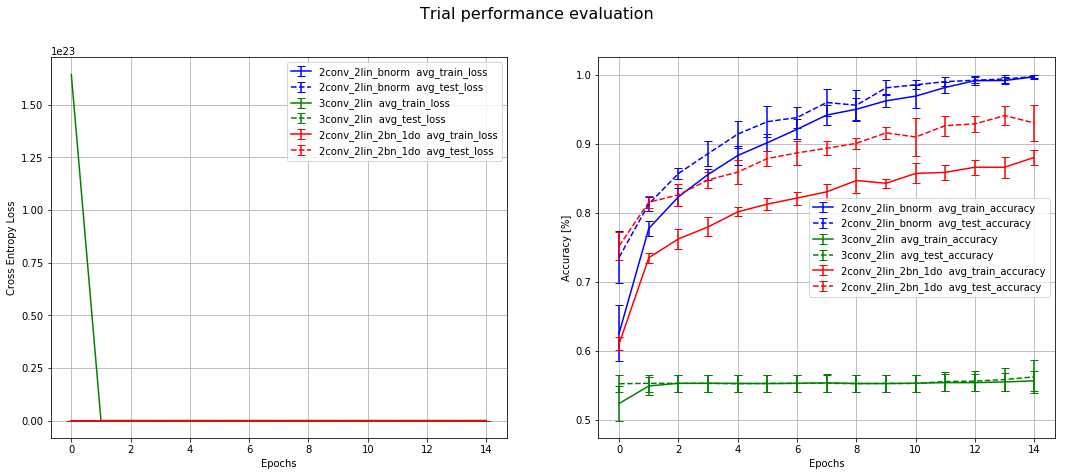

In [22]:
# Plot stuff
plot_this = [[('avg_train_loss','std_train_loss'),('avg_test_loss','std_test_loss')], \
             [('avg_train_accuracy','std_train_accuracy'),('avg_test_accuracy','std_test_accuracy')]]
axes, extrema = plot_performance(trial_summaries, plot_this, suptitle='Trial performance evaluation')
axes[0].set_ylabel('Cross Entropy Loss')
axes[1].set_ylabel('Accuracy [%]');

# Training for the digit classes

In [12]:
# Train for classes and not the target.

dataset_digit = DlDataset(N, normalize=True, upsample=None, split_dataset = True)

datasetShape_digit = list(dataset_digit.__shape__()[1:])

In [13]:
# The same net using NumNet class
# Dropout layer
# {'Type':'DropoutLayer', 'p':0.2}
models_digit = []

# 2 convolutional layers followed by 2 linear layers
config_2c_2l = [{'Type': 'ConvLayer', 'out_channels':8, 'activation':'ReLU()', 'kernel_size':5},
          {'Type': 'ConvLayer', 'out_channels':16, 'activation':'ReLU()', 'kernel_size':3},
          {'Type': 'LinearLayer', 'out_features':32, 'activation':'ReLU()'},
          {'Type': 'LinearLayer', 'out_features':10}]
models_digit.append(NumNet(datasetShape_digit, config_2c_2l, name='2conv_2lin'))

# 2 convolutional layers followed by 2 linear layers with batch norm after each conv layer
config_2c_2l_2bn = [{'Type': 'ConvLayer', 'out_channels':8, 'activation':'ReLU()', 'kernel_size':5},
          {'Type': 'BatchNormLayer'},
          {'Type': 'ConvLayer', 'out_channels':16, 'activation':'ReLU()', 'kernel_size':3},
          {'Type': 'BatchNormLayer'},
          {'Type': 'LinearLayer', 'out_features':32, 'activation':'ReLU()'},
          {'Type': 'LinearLayer', 'out_features':10}]
models_digit.append(NumNet(datasetShape_digit, config_2c_2l_2bn, name='2conv_2lin_2bn'))

# 3 convolutional layers followed by 2 linear layers
config_3c_2l = [{'Type': 'ConvLayer', 'out_channels':4, 'activation':'ReLU()', 'kernel_size':5},
          {'Type': 'ConvLayer', 'out_channels':8, 'activation':'ReLU()', 'kernel_size':3},
          {'Type': 'ConvLayer', 'out_channels':16, 'activation':'ReLU()', 'kernel_size':3},
          {'Type': 'LinearLayer', 'out_features':32, 'activation':'ReLU()'},
          {'Type': 'LinearLayer', 'out_features':10}]
models_digit.append(NumNet(datasetShape_digit, config_3c_2l, name='3conv_2lin'))

# 2 convolutional layers with batch norm and 1 maxpool and 1 dropout, followed by 2 linear layers 
config_2c_2l_2bn_1do = [{'Type': 'ConvLayer', 'out_channels':32, 'activation':'ReLU()', 'kernel_size':5},
          {'Type': 'MaxPoolLayer', 'pooling':2, 'stride':2},
          {'Type': 'BatchNormLayer'},
          {'Type': 'DropoutLayer', 'p':0.5},
          {'Type': 'ConvLayer', 'out_channels':64, 'activation':'ReLU()', 'kernel_size':3},
          #{'Type': 'MaxPoolLayer', 'pooling':2, 'stride':2},
          {'Type': 'BatchNormLayer'},
          {'Type': 'LinearLayer', 'out_features':128, 'activation':'ReLU()'},
          #{'Type': 'DropoutLayer', 'p':0.5},
          {'Type': 'LinearLayer', 'out_features':10}]
models_digit.append(NumNet(datasetShape_digit, config_2c_2l_2bn_1do, name='2conv_2lin_2bn_1do'))

for model in models_digit:
    model.summary()

 
Model '2conv_2lin'
Number              Layer               Input shape         Output shape        Trainable params    
0                   Conv2d              [1, 14, 14]         [8, 10, 10]         208
1                   Conv2d              [8, 10, 10]         [16, 8, 8]          1168
2                   Linear              1024                32                  32800
3                   Linear              32                  10                  330
----------------------------------------------------------------------------------------------------
Total number of trainable parameters: 34506
----------------------------------------------------------------------------------------------------
 
Model '2conv_2lin_2bn'
Number              Layer               Input shape         Output shape        Trainable params    
0                   Conv2d              [1, 14, 14]         [8, 10, 10]         208
1                   BatchNorm2d         [8, 10, 10]         [8, 10, 10]         16


In [14]:
# Train parameter
epochs = 15
mini_batch_size = 100
eta = 5e-2
lambda_l2 = 1e-3
gamma = 0.2
depth = 4
n_filters = 3

batch_spec = {'batch_size':100, 'shuffle':True, 'num_workers':4}

criterion = torch.nn.CrossEntropyLoss()

# Prepare dataloader
dataloader = []
for mode in ['train','test']:
    if mode == 'train':
        dataset_digit.train()
    elif mode == 'test':
        dataset_digit.test()
    dataloader.append(dataset_digit.return_dataloader(**batch_spec))


In [15]:
# Train each model with the same parameters
perf_summary_digit = []
for model in models_digit[1:4]:
    print("-"*100)
    print("Running model: {}".format(model.name()))
    print("-"*100)
    optim = torch.optim.SGD(model.parameters(), lr=eta, momentum=gamma)
    #optim = torch.optim.Adam(model.parameters(), lr=0.001)
    performance, model = train_net(model, device, optim, criterion, dataloader,
                                    epochs=epochs, lambda_=1e-3, reg_type=None, 
                                    save=False)
    perf_summary_digit.append(ModelPerformanceSummary(model, performance))

----------------------------------------------------------------------------------------------------
Running model: 2conv_2lin_2bn
----------------------------------------------------------------------------------------------------
Epoch 0: Duration: 0.40s, Train Loss: 1.80e-02, Train Acc: 0.42, Val Loss: 1.44e-02, Val Acc: 0.67
Epoch 1: Duration: 0.39s, Train Loss: 8.66e-03, Train Acc: 0.76, Val Loss: 8.44e-03, Val Acc: 0.83
Epoch 2: Duration: 0.40s, Train Loss: 5.65e-03, Train Acc: 0.84, Val Loss: 5.31e-03, Val Acc: 0.87
Epoch 3: Duration: 0.38s, Train Loss: 4.27e-03, Train Acc: 0.89, Val Loss: 3.72e-03, Val Acc: 0.92
Epoch 4: Duration: 0.40s, Train Loss: 3.33e-03, Train Acc: 0.92, Val Loss: 2.87e-03, Val Acc: 0.93
Epoch 5: Duration: 0.40s, Train Loss: 2.75e-03, Train Acc: 0.93, Val Loss: 2.41e-03, Val Acc: 0.94
Epoch 6: Duration: 0.41s, Train Loss: 2.32e-03, Train Acc: 0.94, Val Loss: 2.01e-03, Val Acc: 0.96
Epoch 7: Duration: 0.48s, Train Loss: 1.97e-03, Train Acc: 0.95, Val Loss: 

Model: 2conv_2lin_2bn        train_loss           min: 0.001 max: 0.018
Model: 2conv_2lin_2bn        test_loss            min: 0.001 max: 0.014
Model: 2conv_2lin_2bn        train_accuracy       min: 0.416 max: 0.993
Model: 2conv_2lin_2bn        test_accuracy        min: 0.674 max: 0.996
Model: 3conv_2lin            train_loss           min: 0.017 max: 0.052
Model: 3conv_2lin            test_loss            min: 0.016 max: 0.023
Model: 3conv_2lin            train_accuracy       min: 0.074 max: 0.403
Model: 3conv_2lin            test_accuracy        min: 0.069 max: 0.421
Model: 2conv_2lin_2bn_1do    train_loss           min: 0.002 max: 0.019
Model: 2conv_2lin_2bn_1do    test_loss            min: 0.001 max: 0.014
Model: 2conv_2lin_2bn_1do    train_accuracy       min: 0.382 max: 0.956
Model: 2conv_2lin_2bn_1do    test_accuracy        min: 0.739 max: 0.980


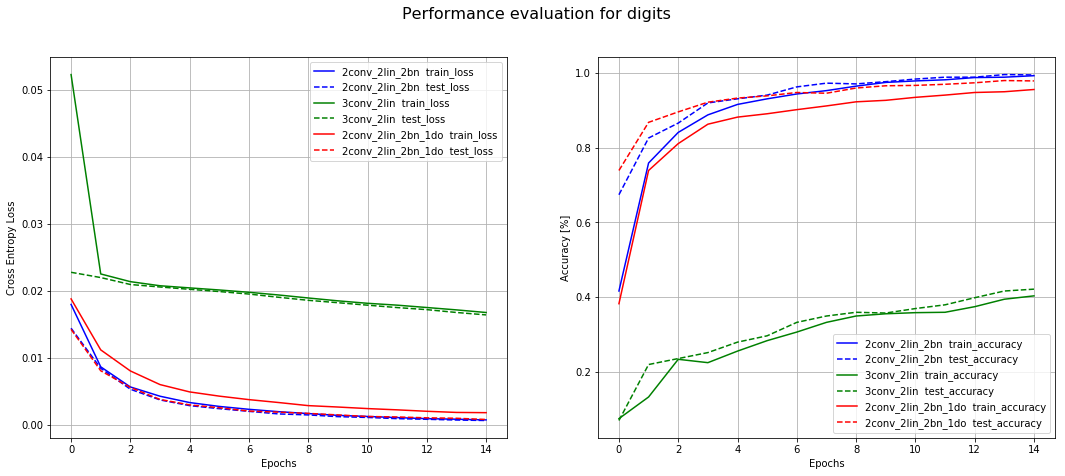

In [23]:
# Plot stuff
axes, extrema = plot_performance(perf_summary_digit, 
                                 [['train_loss','test_loss'],['train_accuracy','test_accuracy']], 
                                 suptitle='Performance evaluation for digits')
axes[0].set_ylabel('Cross Entropy Loss')
axes[1].set_ylabel('Accuracy [%]');

** Multiple training trials using the 'do_train_trials' function: **

In [17]:
trial_summaries_digit = []
for model in models_digit[1:4]:
    print("-"*100)
    print("Running model: {}".format(model.name()))
    print("-"*100)
    optim_spec = {'type':'SGD', 'lr':eta, 'momentum':gamma}
    batch_spec = {'batch_size': 100, 'shuffle':True, 'num_workers':4}
    
    performance = do_train_trials(5, model, device, optim_spec, criterion, dataset_digit, batch_spec,
                                    epochs=epochs, lambda_=1e-3, reg_type=None, 
                                    save=False)
    trial_summaries_digit.append(performance)

----------------------------------------------------------------------------------------------------
Running model: 2conv_2lin_2bn
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Running Trial: 0
----------------------------------------------------------------------------------------------------
Epoch 0: Duration: 0.55s, Train Loss: 1.83e-02, Train Acc: 0.44, Val Loss: 1.41e-02, Val Acc: 0.67
Epoch 1: Duration: 0.57s, Train Loss: 8.75e-03, Train Acc: 0.79, Val Loss: 6.94e-03, Val Acc: 0.86
Epoch 2: Duration: 0.55s, Train Loss: 5.24e-03, Train Acc: 0.86, Val Loss: 4.28e-03, Val Acc: 0.90
Epoch 3: Duration: 0.50s, Train Loss: 3.64e-03, Train Acc: 0.91, Val Loss: 3.02e-03, Val Acc: 0.94
Epoch 4: Duration: 0.49s, Train Loss: 2.85e-03, Train Acc: 0.93, Val Loss: 2.26e-03, Val Acc: 0.94
Epoch 5: Duration: 0.49s, Train Loss: 2.27e-03, Train 

Epoch 10: Duration: 0.50s, Train Loss: 1.13e-03, Train Acc: 0.98, Val Loss: 9.21e-04, Val Acc: 0.99
Epoch 11: Duration: 0.49s, Train Loss: 9.93e-04, Train Acc: 0.98, Val Loss: 8.37e-04, Val Acc: 0.99
Epoch 12: Duration: 0.48s, Train Loss: 8.27e-04, Train Acc: 0.99, Val Loss: 7.34e-04, Val Acc: 1.00
Epoch 13: Duration: 0.45s, Train Loss: 7.18e-04, Train Acc: 0.99, Val Loss: 6.07e-04, Val Acc: 1.00
Epoch 14: Duration: 0.43s, Train Loss: 6.63e-04, Train Acc: 0.99, Val Loss: 5.32e-04, Val Acc: 1.00
Out of 5 trials:
train_loss: Max 0.02 Min 0.02 | Average 0.02, std 0.00
train_accuracy: Max 1.00 Min 0.99 | Average 0.99, std 0.00
test_loss: Max 0.02 Min 0.01 | Average 0.01, std 0.00
test_accuracy: Max 1.00 Min 0.99 | Average 1.00, std 0.00
train_target_accuracy: Max 0.97 Min 0.96 | Average 0.97, std 0.00
test_target_accuracy: Max 0.97 Min 0.96 | Average 0.97, std 0.00
----------------------------------------------------------------------------------------------------
Running model: 3conv_2lin

Epoch 5: Duration: 0.51s, Train Loss: nan, Train Acc: 0.10, Val Loss: nan, Val Acc: 0.10
Epoch 6: Duration: 0.57s, Train Loss: nan, Train Acc: 0.10, Val Loss: nan, Val Acc: 0.10
Epoch 7: Duration: 0.54s, Train Loss: nan, Train Acc: 0.10, Val Loss: nan, Val Acc: 0.10
Epoch 8: Duration: 0.48s, Train Loss: nan, Train Acc: 0.10, Val Loss: nan, Val Acc: 0.10
Epoch 9: Duration: 0.45s, Train Loss: nan, Train Acc: 0.10, Val Loss: nan, Val Acc: 0.10
Epoch 10: Duration: 0.42s, Train Loss: nan, Train Acc: 0.10, Val Loss: nan, Val Acc: 0.10
Epoch 11: Duration: 0.45s, Train Loss: nan, Train Acc: 0.10, Val Loss: nan, Val Acc: 0.10
Epoch 12: Duration: 0.39s, Train Loss: nan, Train Acc: 0.10, Val Loss: nan, Val Acc: 0.10
Epoch 13: Duration: 0.40s, Train Loss: nan, Train Acc: 0.10, Val Loss: nan, Val Acc: 0.10
Epoch 14: Duration: 0.45s, Train Loss: nan, Train Acc: 0.10, Val Loss: nan, Val Acc: 0.10
Out of 5 trials:
train_loss: Max nan Min nan | Average nan, std nan
train_accuracy: Max 0.89 Min 0.10 | A

Epoch 14: Duration: 0.57s, Train Loss: 1.67e-03, Train Acc: 0.96, Val Loss: 7.42e-04, Val Acc: 0.99
----------------------------------------------------------------------------------------------------
Running Trial: 4
----------------------------------------------------------------------------------------------------
Epoch 0: Duration: 0.58s, Train Loss: 1.77e-02, Train Acc: 0.44, Val Loss: 1.19e-02, Val Acc: 0.77
Epoch 1: Duration: 0.58s, Train Loss: 9.95e-03, Train Acc: 0.76, Val Loss: 6.42e-03, Val Acc: 0.89
Epoch 2: Duration: 0.59s, Train Loss: 6.86e-03, Train Acc: 0.84, Val Loss: 4.30e-03, Val Acc: 0.91
Epoch 3: Duration: 0.59s, Train Loss: 5.39e-03, Train Acc: 0.86, Val Loss: 3.20e-03, Val Acc: 0.93
Epoch 4: Duration: 0.59s, Train Loss: 4.43e-03, Train Acc: 0.90, Val Loss: 2.71e-03, Val Acc: 0.94
Epoch 5: Duration: 0.59s, Train Loss: 3.83e-03, Train Acc: 0.90, Val Loss: 2.31e-03, Val Acc: 0.95
Epoch 6: Duration: 0.61s, Train Loss: 3.48e-03, Train Acc: 0.92, Val Loss: 1.95e-03, Va

Model: 2conv_2lin_2bn        avg_train_loss       min: 0.001 max: 0.018
Model: 2conv_2lin_2bn        avg_test_loss        min: 0.001 max: 0.014
Model: 2conv_2lin_2bn        avg_train_target_accuracy min: 0.820 max: 0.965
Model: 2conv_2lin_2bn        avg_test_target_accuracy min: 0.807 max: 0.965
Model: 3conv_2lin            avg_train_loss       min:   nan max:   nan
Model: 3conv_2lin            avg_test_loss        min:   nan max:   nan
Model: 3conv_2lin            avg_train_target_accuracy min: 0.554 max: 0.619
Model: 3conv_2lin            avg_test_target_accuracy min: 0.549 max: 0.620
Model: 2conv_2lin_2bn_1do    avg_train_loss       min: 0.002 max: 0.019
Model: 2conv_2lin_2bn_1do    avg_test_loss        min: 0.001 max: 0.013
Model: 2conv_2lin_2bn_1do    avg_train_target_accuracy min: 0.780 max: 0.955
Model: 2conv_2lin_2bn_1do    avg_test_target_accuracy min: 0.843 max: 0.972


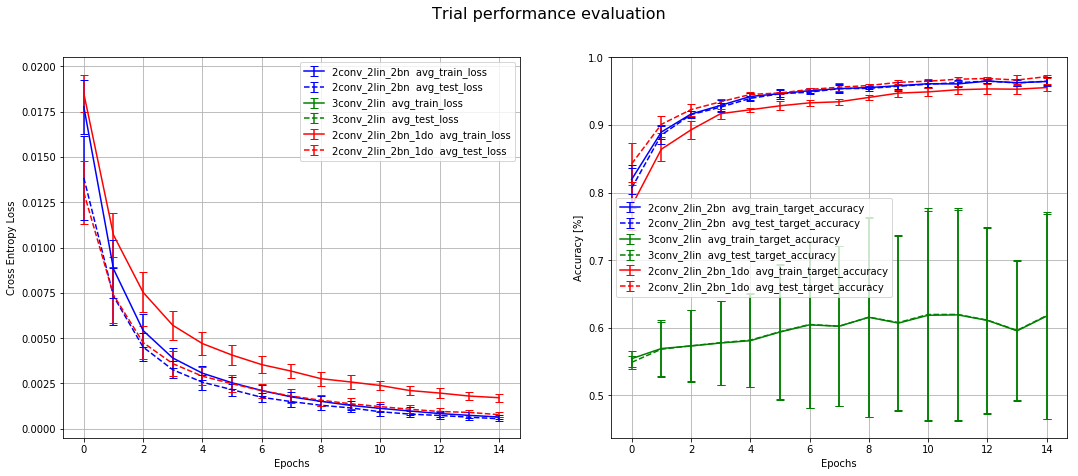

In [24]:
# Plot stuff
plot_this = [[('avg_train_loss','std_train_loss'),('avg_test_loss','std_test_loss')], \
             [('avg_train_target_accuracy','std_train_target_accuracy'),('avg_test_target_accuracy','std_test_target_accuracy')]]
axes, extrema = plot_performance(trial_summaries_digit, plot_this, suptitle='Trial performance evaluation')
axes[0].set_ylabel('Cross Entropy Loss')
axes[1].set_ylabel('Accuracy [%]');

Predicted Class: 2, Real Class: 2
Predicted Class: 7, Real Class: 7
Real Target is: 1
Predicted Target is: 1


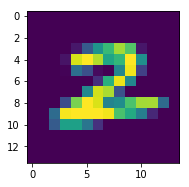

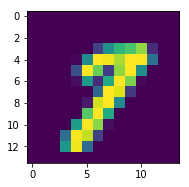

In [20]:
dataset_digit.test()
dataset_digit.selectSplittedDataset('left')
pred_1, classes_1, target_1 = dataset_digit.infere(models_digit[3],11);

dataset_digit.selectSplittedDataset('right')
pred_2, classes_2, target_2 = dataset_digit.infere(models_digit[3],11);
print("Real Target is: {}".format(target_1))
print("Predicted Target is: {}".format((pred_1 <= pred_2).item()))